In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import joblib


In [2]:
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


In [3]:
# Load the dataset
df_raw = pd.read_csv('../../train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

# Select data from a specific start date
end_of_A = '2014-08-08 01:00:00'
df_period_A = df_raw[df_raw['date_time'] <= end_of_A]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_A.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_A.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the index
df['hour'] = df.index.hour

# Split the dataset into features (X) and the target (y)
target = 'traffic_volume'
X = df.drop(target, axis=1)
y = df[target]


In [4]:
# Define a split index for a 90-10 train-test split
split_index = int(len(df) * 0.9)

# Split data
y_train = y.iloc[:split_index]
X_train = X.iloc[:split_index]
y_test = y.iloc[split_index:]
X_test = X.iloc[split_index:]

In [6]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [7]:
# Fit the SARIMAX model with default parameters and slight adjustments
model = SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
results = model.fit(disp=False)

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Forecast on the test set
predictions = results.get_forecast(steps=len(X_test), exog=X_test)
predicted_traffic_volume = predictions.predicted_mean

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [9]:
# Evaluate metrics on the training set for SARIMAX
y_train_pred_sarimax = results.fittedvalues
train_metrics_sarimax = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_sarimax)),
    'MSE': mean_squared_error(y_train, y_train_pred_sarimax),
    'MAE': mean_absolute_error(y_train, y_train_pred_sarimax),
    'MAPE': mape_scorer(y_train, y_train_pred_sarimax)
}

# Evaluate metrics on the validation set for SARIMAX
predictions = results.get_forecast(steps=len(X_test), exog=X_test)
y_val_pred_sarimax = predictions.predicted_mean
val_metrics_sarimax = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_sarimax)),
    'MSE': mean_squared_error(y_test, y_val_pred_sarimax),
    'MAE': mean_absolute_error(y_test, y_val_pred_sarimax),
    'MAPE': mape_scorer(y_test, y_val_pred_sarimax)
}

# Print the metrics for SARIMAX
print("Training Set Metrics (SARIMAX):")
print(train_metrics_sarimax)

print("\nValidation Set Metrics (SARIMAX):")
print(val_metrics_sarimax)


Training Set Metrics (SARIMAX):
{'RMSE': 793.083535106009, 'MSE': 628981.4936562442, 'MAE': 556.1173366125263, 'MAPE': 36.95200665096207}

Validation Set Metrics (SARIMAX):
{'RMSE': 2151.814632390899, 'MSE': 4630306.21217158, 'MAE': 1787.5740293749725, 'MAPE': 181.16559497872012}


C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


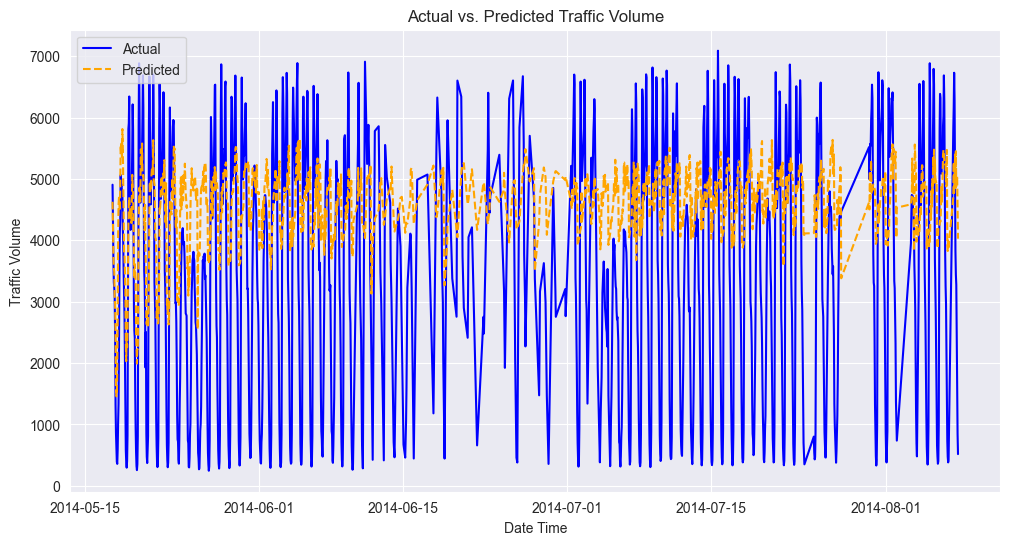

In [10]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predicted_traffic_volume, label='Predicted', color='orange', linestyle='--')
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [11]:
import joblib

# Save the model to a file
joblib.dump(results, 'A_Default_sarimax_model.joblib')

['A_Default_sarimax_model.joblib']

In [12]:
# Reset indices
y_test_reset = y_test.reset_index()
predicted_traffic_volume_reset = predicted_traffic_volume.reset_index(drop=True)

# Slice the first 720 observations
y_test_sliced = y_test_reset.iloc[:720]
predicted_traffic_volume_sliced = predicted_traffic_volume_reset.iloc[:720]

# Extract the date_time information from the reset y_test
date_time_info_sliced = y_test_sliced['date_time']

In [13]:
# Create a DataFrame with the sliced data
df_results = pd.DataFrame({
    'date_time': date_time_info_sliced,
    'actual_traffic_volume': y_test_sliced['traffic_volume'],  # Assuming 'traffic_volume' is the column name in y_test
    'forecasted_traffic_volume': predicted_traffic_volume_sliced
})

# Display the DataFrame
print(df_results)

              date_time  actual_traffic_volume  forecasted_traffic_volume
0   2014-05-17 17:00:00                 4906.0                4628.215904
1   2014-05-17 18:00:00                 4258.0                4251.456950
2   2014-05-17 19:00:00                 3699.0                3735.024880
3   2014-05-17 20:00:00                 3317.0                3539.803412
4   2014-05-17 21:00:00                 3226.0                3488.069686
..                  ...                    ...                        ...
715 2014-07-05 04:00:00                  319.0                4110.464814
716 2014-07-05 05:00:00                  623.0                4184.833620
717 2014-07-05 06:00:00                 1118.0                4348.522315
718 2014-07-05 07:00:00                 1452.0                4302.263745
719 2014-07-05 08:00:00                 2019.0                4369.433482

[720 rows x 3 columns]
